<a href="https://colab.research.google.com/github/Mjboothaus/rewarding-risk/blob/main/notebooks/PortfolioVaR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculating Value at Risk (VaR) of a stock portfolio using Python

## What is Value at risk (VaR)?

Value at risk (VaR) is one statistic used to try and quantify the level of financial risk within a firm or portfolio over a specified time frame. VaR provides an estimate of the maximum loss from a given position or portfolio over a period of time, and you can calculate it across various confidence levels.

Estimating the risk of a portfolio is important to long-term capital growth and risk management, particularly within larger firms or institutions. VaR is typically framed as something like this:

"We have a portfolio VaR of 250,000 AUD over the next month at 95% confidence".
This means that, with 95% confidence, we can say that the portfolio's loss will not exceed 250,000 AUD in a month.
The steps to calculate this metric across a simple portfolio of stocks is presented below.


## How is VaR calculated?

There are two main ways to calculate VaR:
1. Monte Carlo simulation
2. Variance-covariance method.

Here we'll focus on using method (2) (variance-covariance). In short, the variance-covariance method looks at historical price movements (standard deviation, mean price) of a given equity or portfolio of equities over a specified lookback period, and then uses probability theory to calculate the maximum loss within the specified confidence interval. More details are available [here](https://www.investopedia.com/ask/answers/041715/what-variancecovariance-matrix-or-parametric-method-value-risk-var.asp), but we'll calculate it step by step below using Python.

### Assumptions

Before we get started, note that the standard VaR calculation assumes the following:
1. Normal distribution of returns - VaR assumes the returns of the portfolio are normally distributed. This is of course not realistic for most assets, but allows us to develop a baseline using a much more simplistic calculation.
(Modifications can be made to VaR to account for different distributions, but here we'll focus on the standard VaR calculation)
2. Standard market conditions - Like many financial instruments, VaR is best used for considering loss in standard markets, and is not well-suited for extreme/outlier events.

## Steps to calculate the VaR of a portfolio

In order to calculate the VaR of a portfolio, you can follow the steps below:
1. Calculate periodic returns of the stocks in the portfolio
2. Create a covariance matrix based on the returns
3. Calculate the portfolio mean and standard deviation
(weighted based on investment levels of each stock in portfolio)
4. Calculate the inverse of the normal cumulative distribution (PPF) with a specified confidence interval, standard deviation, and mean
5. Estimate the value at risk (VaR) for the portfolio by subtracting the initial investment from the calculation in step (4).

### Reference

https://www.interviewqs.com/blog/value-at-risk

### 0) Setup

In [1]:
from pandas_datareader import data as pdr
import yfinance as yf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm


### 1) Calculate periodic returns of the stocks in the portfolio

In [2]:
# Create our portfolio of equities
# tickers = ["AAPL", "META", "C", "DIS"]
tickers = ["AMP.AX", "ANZ.AX", "CBA.AX", "WBC.AX"]
# Set the investment weights (I arbitrarily picked for example)
weights = np.array([0.25, 0.3, 0.15, 0.3])

# Set an initial investment level (1M AUD - for this US-centric example)
initial_investment = 1_000_000


In [3]:
assert sum(weights) == 1.0


In [4]:
# Download closing prices

data = pdr.get_data_yahoo(tickers, start="2018-01-01", end=dt.date.today())["Close"]

data.tail()


Symbols,AMP.AX,ANZ.AX,CBA.AX,WBC.AX
Date,,,,
2022-06-27,0.980,22.570000,93.739998,19.920000
2022-06-28,0.975,22.420000,93.540001,19.750000
2022-06-29,0.980,22.629999,93.000000,19.940001
2022-06-30,0.955,22.030001,90.379997,19.500000
2022-07-01,0.972,22.160000,90.669998,19.540001


In [5]:
# From the closing prices, calculate periodic returns
returns = data.pct_change()

returns.tail()


Symbols,AMP.AX,ANZ.AX,CBA.AX,WBC.AX
Date,,,,
2022-06-27,0.000000,0.030123,0.039707,0.022587
2022-06-28,-0.005102,-0.006646,-0.002134,-0.008534
2022-06-29,0.005128,0.009367,-0.005773,0.009620
2022-06-30,-0.025510,-0.026513,-0.028172,-0.022066
2022-07-01,0.017801,0.005901,0.003209,0.002051


### 2) Create a covariance matrix based on the returns

This will allow us to calculate the standard deviation and mean of returns across the entire portfolio.

In [6]:
# Generate Var-Cov matrix
cov_matrix = returns.cov()

cov_matrix


Symbols,AMP.AX,ANZ.AX,CBA.AX,WBC.AX
Symbols,,,,
AMP.AX,0.000684,0.000186,0.000161,0.000176
ANZ.AX,0.000186,0.000304,0.000226,0.000267
CBA.AX,0.000161,0.000226,0.000252,0.000211
WBC.AX,0.000176,0.000267,0.000211,0.000297


### 3) Calculate the portfolio mean and standard deviation

In [7]:
# Calculate mean returns for each stock
avg_rets = returns.mean()

# Calculate mean returns for portfolio overall, using dot product to
# normalize individual means against investment weights

# https://en.wikipedia.org/wiki/Dot_product#:~:targetText=In%20mathematics%2C%20the%20dot%20product,and%20returns%20a%20single%20number.

port_mean = avg_rets.dot(weights)

# Calculate portfolio standard deviation

port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

# Calculate mean of investment

mean_investment = (1 + port_mean) * initial_investment

# Calculate standard deviation of investment

stdev_investment = initial_investment * port_stdev


In [8]:
avg_rets


Symbols
AMP.AX   -0.001125
ANZ.AX   -0.000071
CBA.AX    0.000233
WBC.AX   -0.000263
dtype: float64

In [9]:
port_mean


-0.00034655825496324617

In [10]:
port_stdev


0.016008178403935293

In [11]:
mean_investment


999653.4417450367

In [12]:
stdev_investment


16008.178403935293

Next, we can plug these variables into our percentage point function (PPF) below.

### 4) Calculate the inverse of the normal cumulative distribution (PPF) with a specified confidence interval, standard deviation, and mean

In [13]:
# Select our confidence interval (I'll choose 95% here)
conf_level1 = 0.05

# Using SciPy ppf method to generate values for the
# inverse cumulative distribution function to a normal distribution

# Plugging in the mean, standard deviation of our portfolio
# as calculated above

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)


In [14]:
cutoff1


973322.3314364376

### 5) Estimate the value at risk (VaR) for the portfolio by subtracting the initial investment from the calculation in step 4

In [15]:
# Finally, we can calculate the VaR at our confidence interval

var_1d1 = initial_investment - cutoff1

var_1d1


26677.668563562445

Here we are saying with 95% confidence that our portfolio of 1M AUD will not exceed losses greater than 28.9k AUD over a one day period.

### Value at risk over $n$-day time period

What if we wanted to calculate this over a larger window of time? Below we can easily do that by just taking our 1 day VaR and multiplying it by the square root of the time period (this is due to the fact that the standard deviation of stock returns tends to increase with the square root of time).

In [16]:
# Calculate n Day VaR

var_array = []

num_days = 15

for x in range(1, num_days + 1):
    var_array.append(np.round(var_1d1 * np.sqrt(x), 2))
    print(
        f"{str(x)} day VaR @ 95% confidence: {str(np.round(var_1d1 * np.sqrt(x), 2))}"
    )


1 day VaR @ 95% confidence: 26677.67
2 day VaR @ 95% confidence: 37727.92
3 day VaR @ 95% confidence: 46207.08
4 day VaR @ 95% confidence: 53355.34
5 day VaR @ 95% confidence: 59653.08
6 day VaR @ 95% confidence: 65346.68
7 day VaR @ 95% confidence: 70582.48
8 day VaR @ 95% confidence: 75455.84
9 day VaR @ 95% confidence: 80033.01
10 day VaR @ 95% confidence: 84362.2
11 day VaR @ 95% confidence: 88479.82
12 day VaR @ 95% confidence: 92414.15
13 day VaR @ 95% confidence: 96187.7
14 day VaR @ 95% confidence: 99818.7
15 day VaR @ 95% confidence: 103322.17


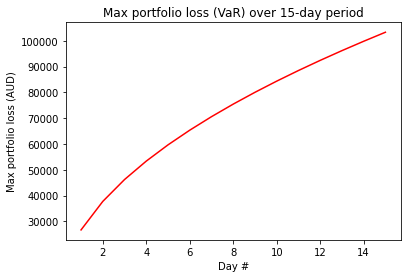

In [17]:
# Build plot

plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (AUD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(range(1, num_days + 1), var_array, "r")


### (Extra) Checking distributions of our equities against normal distribution

As mentioned in the calculation section, we are assuming that the returns of the equities in our portfolio are normally distributed when calculating VaR. Of course, we can't predict that moving forward, but we can at least check how the historical returns have been distributed to help us assess whether VaR is suitable to use for our portfolio.

In [18]:
def plot_return_dist(ticker):
    returns[ticker].hist(bins=40, density=True, histtype="stepfilled", alpha=0.5)
    x = np.linspace(port_mean - 3 * port_stdev, port_mean + 3 * port_stdev, 100)
    plt.plot(x, norm.pdf(x, port_mean, port_stdev), "r")
    plt.title(f"{ticker} returns (binned) vs. normal distribution")
    plt.show()


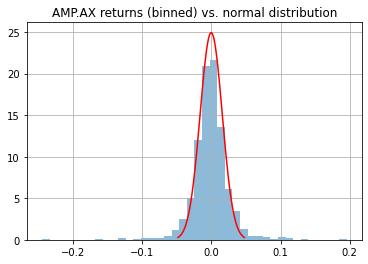

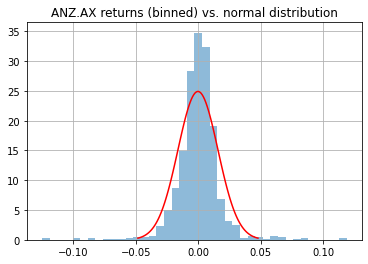

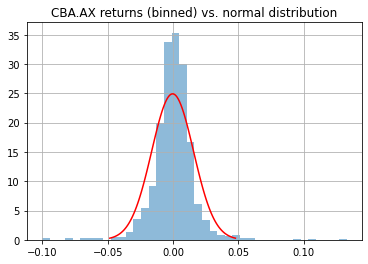

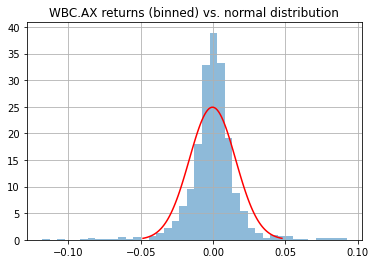

In [19]:
for ticker in tickers:
    plot_return_dist(ticker)


From the above we can see the returns are not really normally distributed for our chosen stocks since 2018.